In [1]:
import pandas as pd
import numpy as np

# utility
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from data_cleaning import clean_raw_data, create_dataset, get_all_results

#viz
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# parallel
import ray
try:
    ray.init()
except:
    print("ray already started")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, StratifiedShuffleSplit, LeaveOneOut
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from augmentdatalib_source.knnor.data_augment import KNNOR
from mlxtend.feature_selection import SequentialFeatureSelector, ExhaustiveFeatureSelector
from feature_selection import FeatureSelector
from tuning import Tuner

# models
from sklearn.svm import SVC

# analysis
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_columns", None) # show all cols


SEED = 42

# reload modules in py files
%load_ext autoreload
%autoreload 2

2023-02-17 11:29:16,316	INFO worker.py:1538 -- Started a local Ray instance.


## 1. Exploration / Cleaning

In [7]:
df = clean_raw_data("Brdi_db_march.xlsx")

X, y = create_dataset(df, target_col="NHL")
print(X.columns)
print("No missing values in X: ", (X.isna().sum() == 0).all())
print("No missing values in y: ", (y.isna().sum() == 0).all())
display(X, y)

Index(['age as of June 1', 'height', 'weight', 'previous concussions?',
       '# of concussions', 'bimanual score: washer', 'Bimanual Score: Button',
       'RT_V', 'RT_HR', 'Delta_RT', 'MT_V', 'MT_HR', 'Delta_MT', 'TMT_V',
       'TMT_HR', 'CMT: V', 'CMT: HR', 'cvRT_V', 'cvRT_HR', 'stdRT_V',
       'stdRT_HR', 'Ball Path_V', 'Ball Path_HR', 'Delta_BallPath',
       'FullPath_V', 'FullPath_HR', 'Delta_Fullpath', 'Corrective_V',
       'Corrective_HR', 'PeakV_V', 'PeakV_HR', 'Delta_PV', 'AE_V', 'AE_HR',
       'Delta_AE', 'VE_V', 'VE_HR', 'Delta: VE', 'AbsOnAxis_V', 'AbsOnAxis_HR',
       'Delta_OnAxis', 'AbsOffAxis_V', 'AbsOffAxis_HR', 'Delta_OffAxis'],
      dtype='object')
No missing values in X:  True
No missing values in y:  True


,age as of June 1,height,weight,previous concussions?,# of concussions,bimanual score: washer,Bimanual Score: Button,RT_V,RT_HR,Delta_RT,MT_V,MT_HR,Delta_MT,TMT_V,TMT_HR,CMT: V,CMT: HR,cvRT_V,cvRT_HR,stdRT_V,stdRT_HR,Ball Path_V,Ball Path_HR,Delta_BallPath,FullPath_V,FullPath_HR,Delta_Fullpath,Corrective_V,Corrective_HR,PeakV_V,PeakV_HR,Delta_PV,AE_V,AE_HR,Delta_AE,VE_V,VE_HR,Delta: VE,AbsOnAxis_V,AbsOnAxis_HR,Delta_OnAxis,AbsOffAxis_V,AbsOffAxis_HR,Delta_OffAxis
0,18,73,193,1,1.000000,20.54,13.022619,426.570000,680.8300,254.26,241.7300,895.6200,653.90,285.4000,1200.6900,43.67,305.07,0.100000,0.210000,42.79000,140.47000,64.82,66.62,1.80,70.00,77.51,7.50,5.18,10.89,211.8900,64.6800,-147.21,9.7100,15.4400,5.73,5.0200,8.7700,1.657381,8.01000,10.940000,2.92,3.790000,7.560000,3.77
1,18,73,180,1,0.578512,19.00,13.022619,432.096614,587.0299,154.93,201.9240,331.0767,129.15,235.6560,637.0870,33.73,306.01,0.100000,0.090000,42.13000,55.27000,59.15,64.11,4.96,65.77,74.54,8.77,6.61,10.42,245.8500,178.1700,-67.68,12.3700,14.6200,2.24,9.3700,8.5000,1.657381,10.69000,9.630000,-1.06,2.040000,5.690000,3.66
2,18,73,196,1,1.000000,20.20,13.022619,398.272727,541.1175,142.84,259.1539,222.6922,-36.46,265.3636,249.5000,6.21,26.81,0.090000,0.280000,34.58000,151.09000,69.48,62.36,-7.12,69.73,73.17,3.44,0.25,10.81,195.6900,238.3500,42.66,5.2200,6.0700,0.84,4.1300,0.8300,1.657381,3.11000,11.610000,8.50,1.940000,0.790000,-1.15
3,18,71,178,1,1.000000,17.20,13.022619,663.000000,1279.9670,616.97,311.8333,578.4696,266.64,371.2000,912.7325,59.37,334.26,0.920000,0.820000,609.51000,1051.09000,69.52,64.02,-5.50,69.52,79.74,10.22,0.00,15.72,457.9600,128.8100,-329.16,3.9600,12.6200,8.66,0.9400,5.2200,1.657381,3.14000,13.250000,10.11,1.580000,8.260000,6.67
4,18,75,202,1,1.000000,24.00,13.022619,490.080000,767.1300,277.06,204.8800,300.9600,96.07,208.7100,760.9400,3.83,459.98,0.080000,0.120000,38.93000,92.45000,66.88,65.63,-1.25,69.12,81.85,12.73,2.24,16.22,250.6800,195.3700,-55.30,8.9900,13.4200,4.42,2.3500,8.9200,1.657381,7.44721,8.597285,1.15,1.791101,6.231146,4.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,18,71,180,0,0.000000,28.16,16.590000,394.333523,564.9610,170.63,219.4186,307.9426,88.52,264.7517,795.7188,45.33,487.78,0.079466,0.155812,31.33609,88.02793,68.56,60.64,-7.92,73.86,74.72,0.86,5.30,14.08,264.3481,181.3646,-82.98,8.9438,13.5755,4.63,9.8023,9.8900,0.090000,4.19970,11.500800,7.30,1.998500,2.271900,0.27
119,18,72,173,0,0.000000,23.73,13.250000,503.523240,615.5299,112.01,367.6700,243.2263,-124.44,440.0524,424.0147,72.38,180.79,0.368532,0.330843,185.56450,203.64400,66.37,67.83,1.46,70.30,68.69,-1.61,3.93,0.86,176.2499,199.9319,23.68,9.5019,11.2735,1.77,5.2539,3.4089,-1.840000,8.32080,9.869900,1.55,1.998500,3.648200,1.65
120,18,74,200,0,0.000000,20.40,14.220000,468.076923,651.6511,183.57,385.9464,388.2311,2.28,409.2898,418.9641,23.34,30.73,0.127080,0.196829,59.48314,128.26380,64.06,72.65,8.59,70.01,72.00,1.98,5.95,-0.65,162.1795,169.4676,7.29,9.8984,7.4700,-2.43,4.9097,5.5820,0.670000,9.29020,2.385000,-6.91,0.565600,3.591600,3.03
121,17,74,194,0,0.000000,21.29,13.120000,379.600000,539.6085,160.01,234.0372,255.1963,21.16,280.5859,618.5576,46.55,363.36,0.106403,0.119280,40.39059,64.36458,69.64,59.83,-9.81,72.07,72.40,0.32,2.44,12.57,250.5720,186.2882,-64.28,6.0175,15.5713,9.55,5.7879,4.6840,-1.100000,2.62540,13.951700,11.33,1.838200,3.110900,1.27


0      0
1      0
2      0
3      0
4      0
      ..
118    1
119    1
120    1
121    1
122    1
Name: NHL, Length: 123, dtype: int64

In [28]:
count_one = y.value_counts()[1]
count_zero = y.value_counts()[0]

print(1 / count_zero, 1 / count_one)
print(1 / (count_one / len(y)), 1 / (count_zero / len(y)))

0.02040816326530612 0.013513513513513514
1.662162162162162 2.510204081632653


In [199]:
def seaborn_conf_matrix(cm):
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

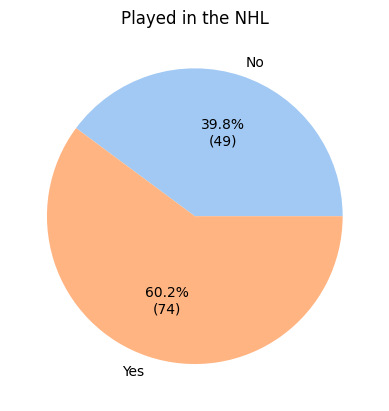

In [3]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format


def plot_pie(df, col, title):
    concussions = df.groupby(col).height.count()
    colors = sns.color_palette('pastel')[0:5]

    plt.title(label=title)
    plt.pie(concussions, labels = ["No", "Yes"], colors = colors, autopct=autopct_format(concussions))
    plt.show()


plot_pie(df, "NHL", "Played in the NHL")

## 2. Sampling

* **SMOTE**
* **ADASYN**
* **RANDOM** Over Sampling
* **KNNOR** - K-nearest neighbors oversampling

In [96]:
def balance_dataset(X, y, type="SMOTE"):
    techniques = {
        "SMOTE" : SMOTE(random_state=SEED),
        "ADASYN" : ADASYN(random_state=SEED),
        "RANDOM" : RandomOverSampler(random_state=SEED),
        "KNNOR" : KNNOR(),

    }

    if type == "weighted":
        count_one = y.value_counts()[1]
        count_zero = y.value_counts()[0]
        
        y = pd.DataFrame(y)
        y[y["NHL"] == 1] = 1 / count_one
        y[y["NHL"] == 0] = 1 / count_zero

        return X, np.array(y)

    sampler = techniques[type]


    if type == "KNNOR":
        X_cols = X.columns
        y_name = y.name

        X, y, _, _ = sampler.fit_resample(X.values, y.values)
        # y = y.reshape(-1, 1)

        # because of how the library is setup have to convert back to DF/Series
        X = pd.DataFrame(X, columns=X_cols)
        y = pd.Series(y, name=y_name)
    else:
        X, y = sampler.fit_resample(X, y,)

    return X, y


# X_smote, y_smote = balance_dataset(X, y, type="SMOTE")
# X_adasyn, y_adasyn = balance_dataset(X, y, type="ADASYN")
# X_random, y_random = balance_dataset(X, y, type="RANDOM")
# X_knnor, y_knnor = balance_dataset(X, y, type="KNNOR")

X_weighted, y_weighted = balance_dataset(X, y, type="weighted")

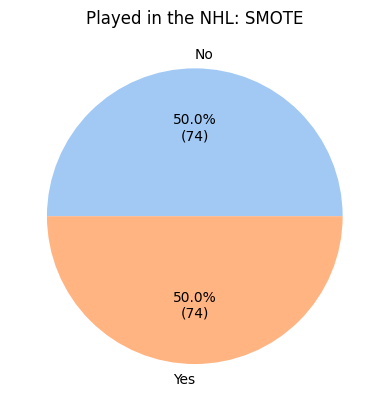

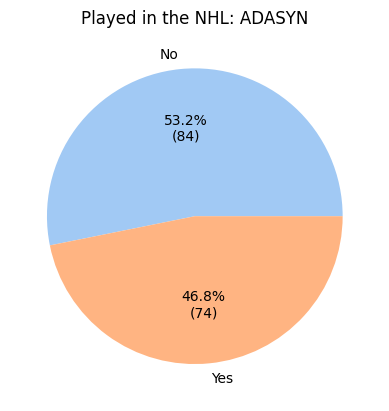

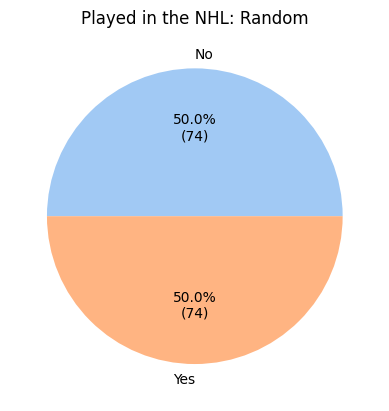

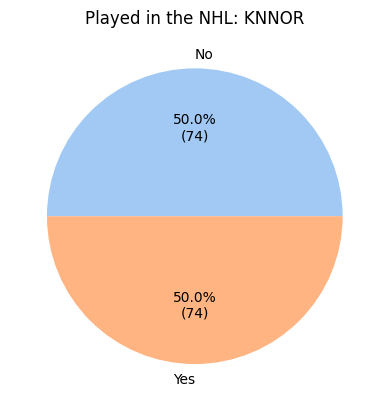

In [57]:
plot_pie(pd.concat([X_smote, y_smote], axis=1), "NHL", "Played in the NHL: SMOTE")
plot_pie(pd.concat([X_adasyn, y_adasyn], axis=1), "NHL", "Played in the NHL: ADASYN")
plot_pie(pd.concat([X_random, y_random], axis=1), "NHL", "Played in the NHL: Random")
plot_pie(pd.concat([X_knnor, y_knnor], axis=1), "NHL", "Played in the NHL: KNNOR")

## 3. Feature Selection


* **Pearson Correlation** - Two features that are highly correlated with each other are redundant
* **Extra Trees Classifier** - Randomized decision trees on subsamples of the dataset to determine feature importance
* **Forward Feature Selection** - S.O.A, parallelized

### 3.1 Pearson Correlation

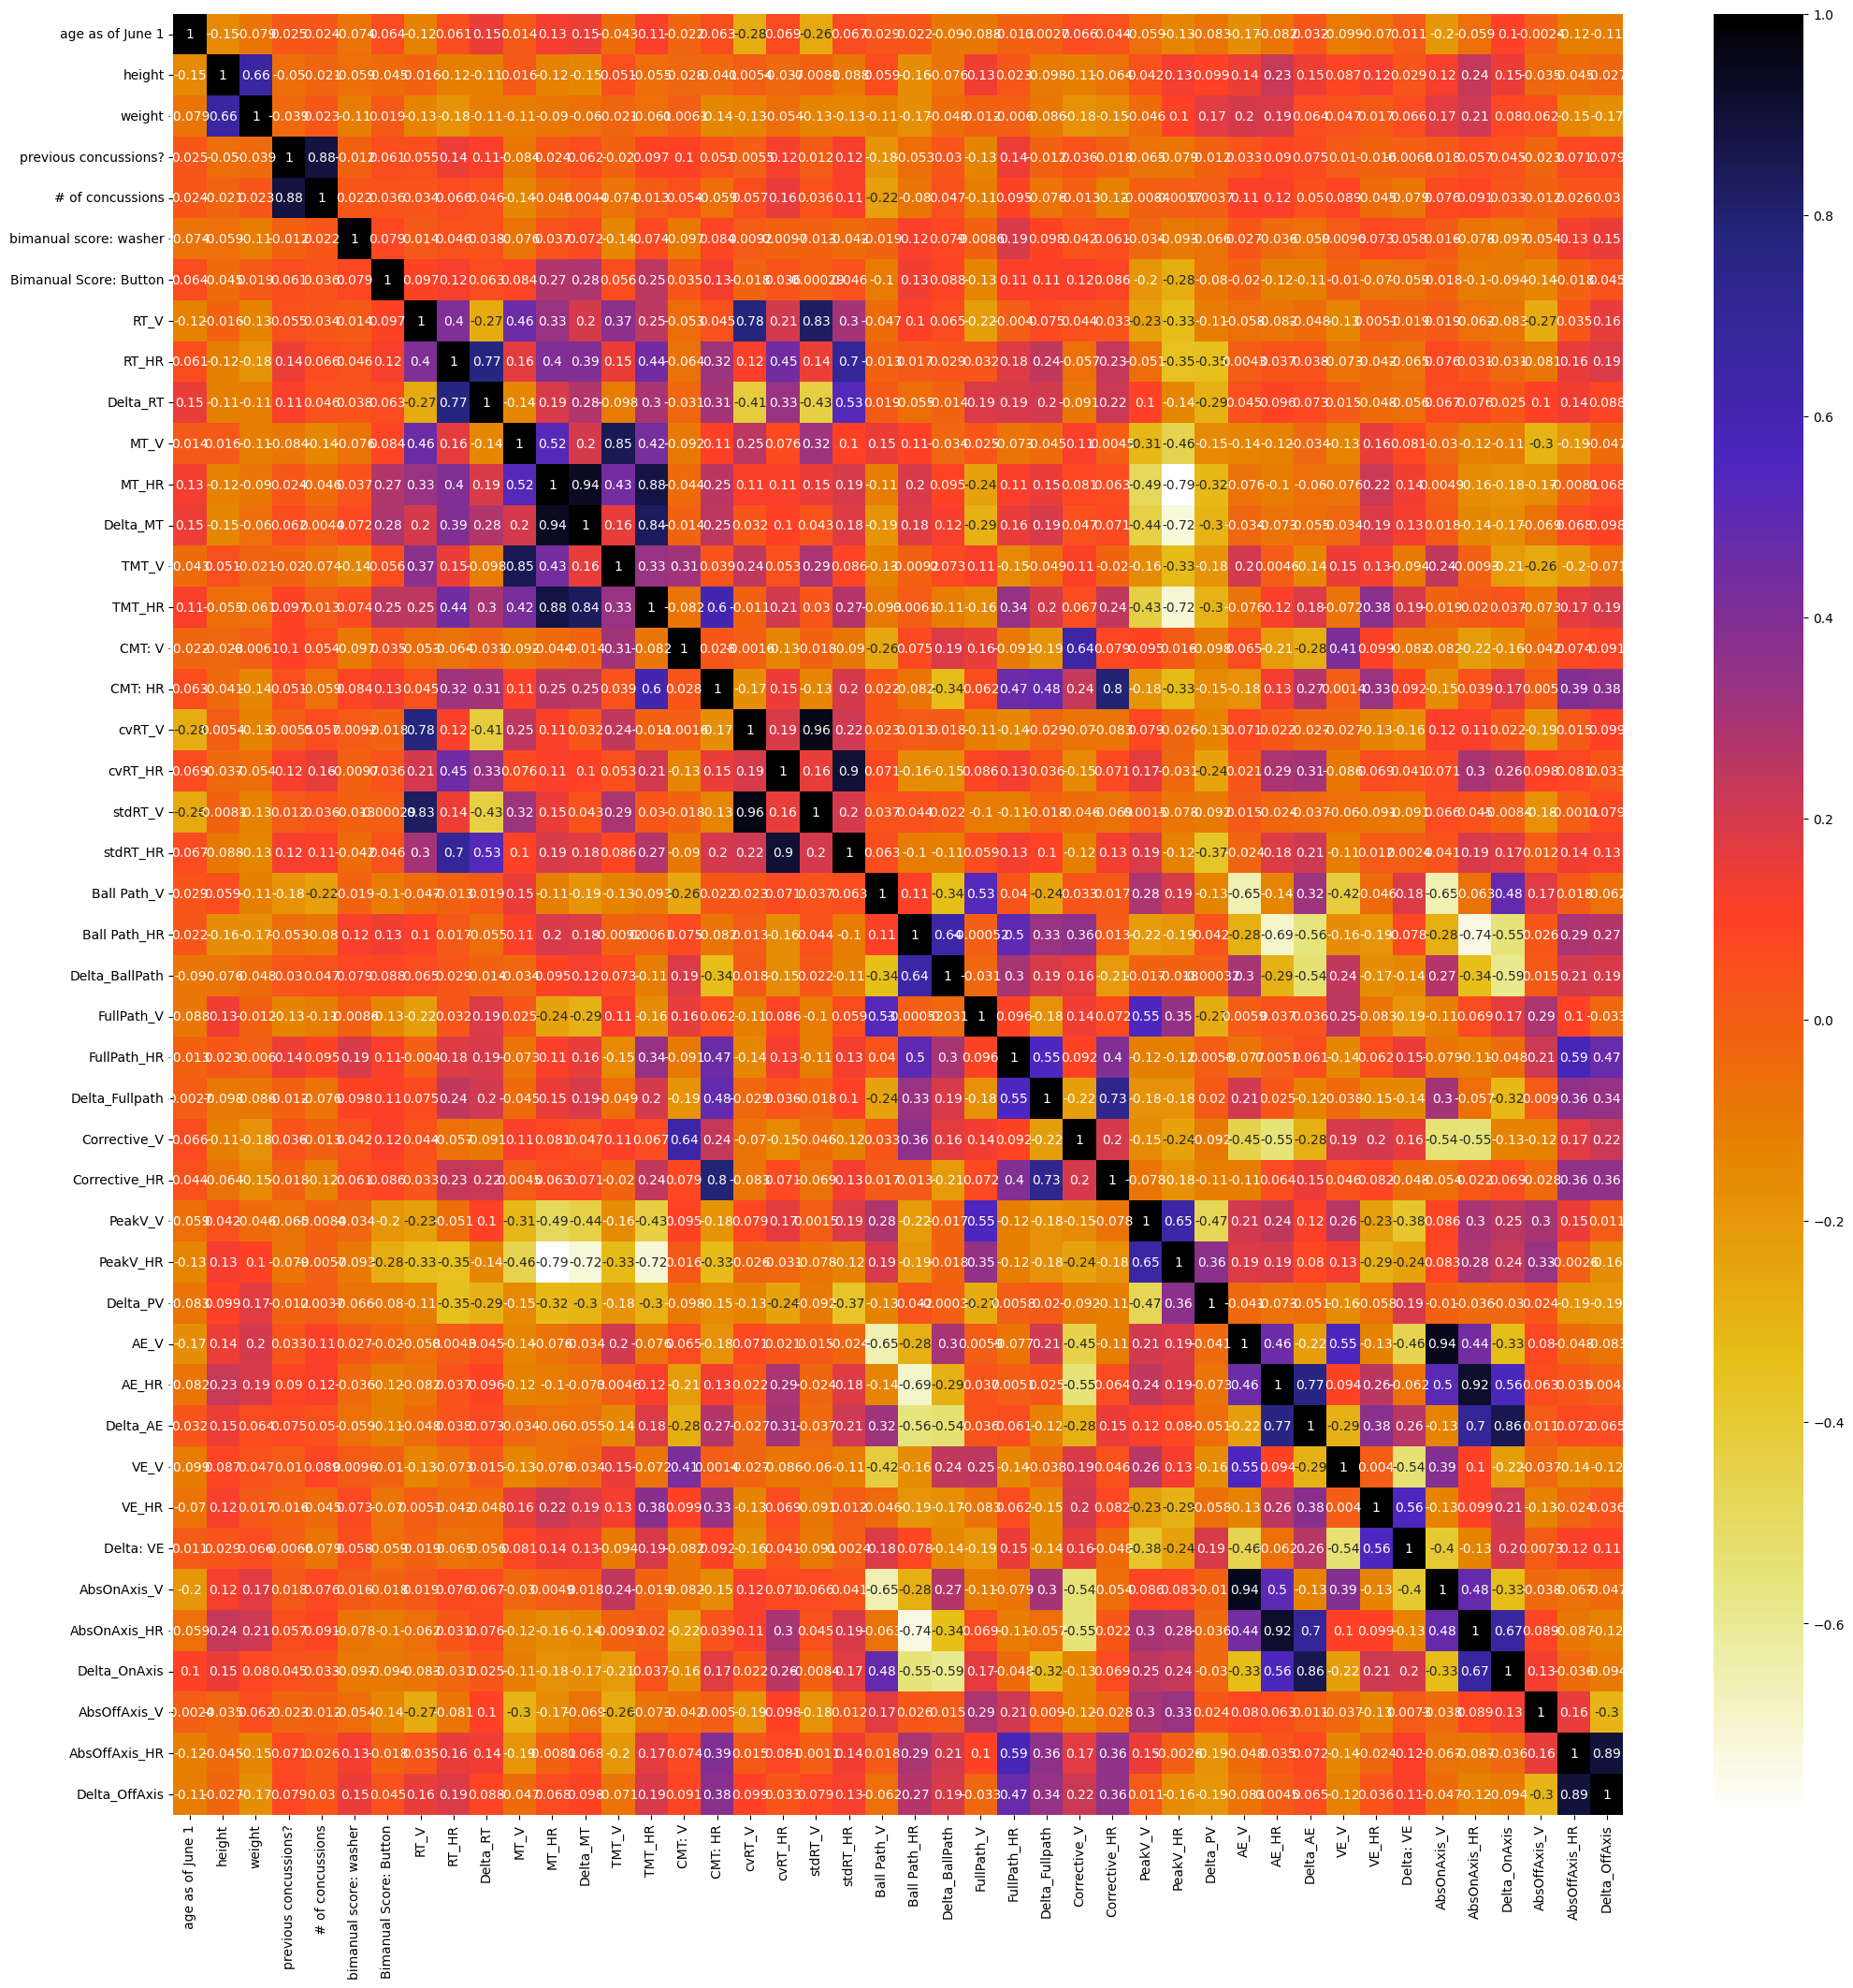

Features that exhibit pearson correlation of .7 or less:



{'# of concussions',
 'AbsOnAxis_HR',
 'AbsOnAxis_V',
 'Corrective_HR',
 'Delta_AE',
 'Delta_MT',
 'Delta_OffAxis',
 'Delta_OnAxis',
 'Delta_RT',
 'PeakV_HR',
 'TMT_HR',
 'TMT_V',
 'cvRT_V',
 'stdRT_HR',
 'stdRT_V'}

In [58]:
def plot_correlation_heatmap(X):
    cor = pd.DataFrame(X).corr()
    plt.figure(figsize=(25,25))
    sns.heatmap(cor, cmap=plt.cm.CMRmap_r,annot=True)
    plt.show()  

def correlation(dataset, threshold):

    """
    Find all pairs of collumns with correllation > .7. Add one of the pairs to a set to be dropped
    """
    col_corr = set()  
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i]                  
                col_corr.add(colname)
    return col_corr  



plot_correlation_heatmap(X)
orthogonal_features = correlation(X, .7)
print("Features that exhibit pearson correlation of .7 or less:\n",)
display(orthogonal_features)

### 3.2 Extra Trees 

In [59]:
from sklearn.ensemble import ExtraTreesClassifier
def get_n_important_features(X, y, n_features=10):
    model = ExtraTreesClassifier(random_state=SEED)
    model.fit(X, y)
    feat_importances = pd.Series(model.feature_importances_, index=X.columns).nlargest(n_features)
    
    top_n_columns=feat_importances.keys().to_list()

    top_n_features = pd.DataFrame({'importance' : feat_importances}).sort_values(by="importance", ascending=False)
    return top_n_features

top_n_features = get_n_important_features(X, y, n_features=15)
display(top_n_features)

print("\nFeatures that are orthogonal and in the top 15 features:")
set(list(top_n_features.index)).intersection(set(list(orthogonal_features)))

,importance
Delta_AE,0.034672
Ball Path_HR,0.033021
Delta: VE,0.030885
PeakV_HR,0.030700
Delta_BallPath,0.029402
Delta_OnAxis,0.029325
cvRT_HR,0.028531
AbsOffAxis_V,0.026675
FullPath_V,0.025918
CMT: V,0.025171



Features that are orthogonal and in the top 15 features:


{'AbsOnAxis_HR', 'Delta_AE', 'Delta_OnAxis', 'PeakV_HR', 'TMT_V'}

### 3.3 Forward Selection

*See ./training_output for all results*

In [39]:
def get_cross_validation(X, y, test_size=.2, n_splits=2, type="stratified"):
    if type == "stratified":
        return list(StratifiedShuffleSplit(test_size=test_size, n_splits=n_splits, random_state=SEED).split(X, y))
    elif type == "leave_one_out":
        return list(LeaveOneOut().split(X, y))

kf = get_cross_validation(X, y)

### 3.3.1 Forward Feature Selection

* Forward Feature selection, 10-20 features, floating, f1 scoring
* 90% training, 10% validation, stratified 
* Cross Validation: 80% training, 20% testing, stratified, 2 folds

In [200]:
def train_simple_model(model, kf, X, y, display_cm=False):
    # X = X[features]

    scores = []
    
    all_ytest = []
    all_ypred = []
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores.append(f1_score(y_test, y_pred))

        all_ytest.extend(y_test)
        all_ypred.extend(y_pred)


    if display_cm:
        seaborn_conf_matrix(confusion_matrix(all_ytest, all_ypred))
    return np.mean(scores)

### Train SVC

Steps: 
1) Split into train/val 80/20 stratified split 
2) Scale X_train 
3) Balance X_train, y_train
4) Feature Selection using cross-validation and all features
5) Keep only best features in X_val
6) Scale X_val (seperately from X_train)
7) Retrain model on X_val using CV and best features

### Feature Selection SVC

In [222]:
X, y = create_dataset(clean_raw_data("Brdi_db_march.xlsx"), target_col="NHL")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=SEED, stratify=y)

model = SVC(random_state=SEED, kernel="linear", C=.1, class_weight="balanced")
kwargs = {"selection_type":"forward", "floating":True, "scoring":"f1", "k_features": len(X.columns), "cv": get_cross_validation(X_train, y_train)}
cols = X.columns

# scale training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)

# balance data after scaling
X_train, y_train = balance_dataset(X_train, y_train, type="SMOTE")


# perform feature selection
ftsl = FeatureSelector(model, **kwargs)
ftsl = ftsl.fit(X_train, y_train)
results = ftsl.get_results(cols)
features_svc = list(map(lambda x: x.replace("'", ""), list(results.iloc[0].features)))
features_svc

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using ba

here


['age as of June 1',
 'height',
 'bimanual score: washer',
 'Bimanual Score: Button',
 'Delta_RT',
 'MT_V',
 'MT_HR',
 'Delta_MT',
 'TMT_V',
 'TMT_HR',
 'CMT: V',
 'CMT: HR',
 'cvRT_V',
 'stdRT_V',
 'Ball Path_V',
 'FullPath_V',
 'FullPath_HR',
 'Corrective_V',
 'Corrective_HR',
 'PeakV_V',
 'PeakV_HR',
 'Delta_PV',
 'AE_V',
 'AE_HR',
 'Delta_AE',
 'VE_V',
 'AbsOnAxis_V']

Retrain on best features and test

Mean F1 Score:  0.6898395721925134
Train-Val Split 80/20
CV, done on train and val: Kfold = 2, test = 20%
Features:  ['age as of June 1', 'height', 'bimanual score: washer', 'Bimanual Score: Button', 'Delta_RT', 'MT_V', 'MT_HR', 'Delta_MT', 'TMT_V', 'TMT_HR', 'CMT: V', 'CMT: HR', 'cvRT_V', 'stdRT_V', 'Ball Path_V', 'FullPath_V', 'FullPath_HR', 'Corrective_V', 'Corrective_HR', 'PeakV_V', 'PeakV_HR', 'Delta_PV', 'AE_V', 'AE_HR', 'Delta_AE', 'VE_V', 'AbsOnAxis_V']


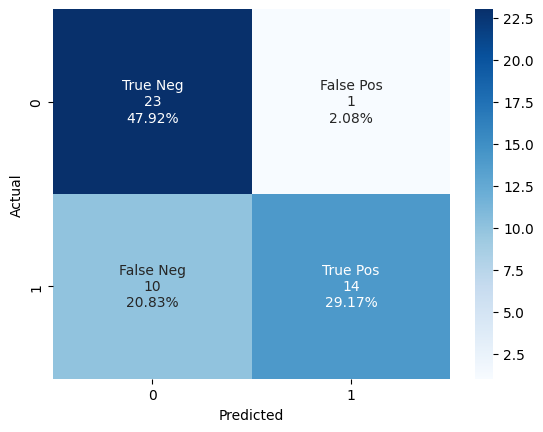

In [221]:
# use best features to retrain / test model
# new X and y split into train and test in cross validation
X_sfs = ftsl.selector.transform(X_train)
y_sfs = y_train


X_val_sfs = ftsl.selector.transform(X_val)

# scale test data
scaler2 = StandardScaler()
X_sfs = scaler2.fit_transform(X_sfs, y_sfs)


# train model on test data
mean_f1 = train_simple_model(model, get_cross_validation(X_sfs, y_sfs), X_sfs, y_sfs, display_cm=True)
print("Mean F1 Score: ", mean_f1,)
print("Train-Val Split 80/20")
print("CV, done on train and val: Kfold = 2, test = 20%")
print("Features: ", features_svc)



## Train Decision Tree

In [148]:
from feature_selection import FeatureSelector
from sklearn.tree import DecisionTreeClassifier

kf = get_cross_validation(X_train, y_train)
X_train_columns = X_train.columns

model1 = DecisionTreeClassifier(random_state=SEED, max_depth=10, max_features='log2', min_samples_split=1)

kwargs = {"selection_type":"forward", "floating":True, "scoring":"f1", "k_features": len(X.columns), "cv":kf}
# scale all data for feature selection
scaler = StandardScaler()
X_train_fs = scaler.fit_transform(X, y)
# balance data after scaling
X_train_fs, y_train_fs = balance_dataset(X_train_fs, y, type="SMOTE")


# perform feature selection
ftsl = FeatureSelector(model1, **kwargs)
ftsl = ftsl.fit(X_train_fs, y_train_fs)
results = ftsl.get_results(X_train_columns)
features = list(map(lambda x: x.replace("'", ""), list(results.iloc[0].features)))

# # use best features to train new model
X_retrain = X[features]

# scale test data
scaler2 = StandardScaler()
X_retrain = scaler2.fit_transform(X_retrain, y)


# train model on test data
mean_f1 = train_simple_model(model1, get_cross_validation(X_retrain, y), X_retrain, y)
print("Mean F1 Score: ", mean_f1,)
print("Train-Val Split 80/20")
print("CV, done on train and val: Kfold = 2, test = 20%")
print("Features: ", features)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
12102.89s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
12102.91s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
12102.93s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
12102.94s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
12102.95s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
12102.96s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
12102.96s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
12102.98s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
12102.98s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
12102.99s - pydevd: Sending message related to process bein

Mean F1 Score:  0.6436781609195402
Train-Val Split 80/20
CV, done on train and val: Kfold = 2, test = 20%
Features:  ['age as of June 1', 'height', 'weight', 'previous concussions?', '# of concussions', 'bimanual score: washer', 'Bimanual Score: Button', 'RT_V', 'RT_HR', 'Delta_RT', 'MT_V', 'Delta_MT', 'TMT_V', 'CMT: V', 'cvRT_V', 'cvRT_HR', 'stdRT_V', 'stdRT_HR', 'Delta_BallPath', 'FullPath_HR', 'Delta_Fullpath', 'Corrective_V', 'PeakV_V', 'Delta_PV', 'AE_HR', 'Delta: VE', 'AbsOnAxis_V', 'Delta_OnAxis', 'AbsOffAxis_V']


In [147]:
feat = ['age as of June 1', 'height', 'weight', 'previous concussions?', '# of concussions', 'bimanual score: washer', 'Bimanual Score: Button', 'RT_V', 'RT_HR', 'Delta_RT', 'MT_V', 'Delta_MT', 'TMT_V', 'CMT: V', 'cvRT_V', 'cvRT_HR', 'stdRT_V', 'stdRT_HR', 'Delta_BallPath', 'FullPath_HR', 'Delta_Fullpath', 'Corrective_V', 'PeakV_V', 'Delta_PV', 'AE_HR', 'Delta: VE', 'AbsOnAxis_V', 'Delta_OnAxis', 'AbsOffAxis_V']
train_simple_model(model1, get_cross_validation(X[feat].values, y), X[feat].values, y)

0.6436781609195402

In [143]:
np.where(y_val == 1)[0].shape[0]

len(y_val)

25

## Train Random Forest

In [133]:
from feature_selection import FeatureSelector
from sklearn.ensemble import RandomForestClassifier

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
X_val2, yval2 = X_val, y_val
kf = get_cross_validation(X_train, y_train)
X_train_columns = X_train.columns

model1 = RandomForestClassifier(random_state=SEED,)
model2 = clone(model1)

kwargs = {"selection_type":"forward", "floating":True, "scoring":"f1", "k_features": len(X.columns), "cv":kf}


# scale training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)

# balance data after scaling
X_train, y_train = balance_dataset(X_train, y_train, type="SMOTE")


# perform feature selection
ftsl = FeatureSelector(model1, **kwargs)
ftsl = ftsl.fit(X_train, y_train)
results = ftsl.get_results(X_train_columns)
features = list(map(lambda x: x.replace("'", ""), list(results.iloc[0].features)))

# use best features on test data
X_val = X_val[features]

# scale test data
scaler2 = StandardScaler()
X_val = scaler2.fit_transform(X_val, y_val)

# train model on test data
mean_f1 = train_simple_model(model2, get_cross_validation(X_val, y_val), X_val, y_val)
print("Mean F1 Score: ", mean_f1,)
print("Train-Val Split 80/20")
print("CV, done on train and val: Kfold = 2, test = 20%")
print("Features: ", features)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using ba

Mean F1 Score:  0.7619047619047619
Train-Val Split 80/20
CV, done on train and val: Kfold = 2, test = 20%
Features:  ['age as of June 1', 'height', 'weight', '# of concussions', 'Delta_RT', 'MT_V', 'TMT_V', 'CMT: V', 'stdRT_HR', 'Ball Path_V', 'Ball Path_HR', 'Delta_BallPath', 'FullPath_V', 'FullPath_HR', 'Corrective_V', 'PeakV_V', 'Delta_AE', 'VE_V', 'Delta_OnAxis', 'AbsOffAxis_V']


## Train MLP


In [134]:
from feature_selection import FeatureSelector
from sklearn.linear_model import LogisticRegression

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
X_val2, yval2 = X_val, y_val
kf = get_cross_validation(X_train, y_train)
X_train_columns = X_train.columns

model1 = LogisticRegression(random_state=SEED,)
model2 = clone(model1)

kwargs = {"selection_type":"forward", "floating":True, "scoring":"f1", "k_features": len(X.columns), "cv":kf}


# scale training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)

# balance data after scaling
X_train, y_train = balance_dataset(X_train, y_train, type="SMOTE")


# perform feature selection
ftsl = FeatureSelector(model1, **kwargs)
ftsl = ftsl.fit(X_train, y_train)
results = ftsl.get_results(X_train_columns)
features = list(map(lambda x: x.replace("'", ""), list(results.iloc[0].features)))

# use best features on test data
X_val = X_val[features]

# scale test data
scaler2 = StandardScaler()
X_val = scaler2.fit_transform(X_val, y_val)

# train model on test data
mean_f1 = train_simple_model(model2, get_cross_validation(X_val, y_val), X_val, y_val)
print("Mean F1 Score: ", mean_f1,)
print("Train-Val Split 80/20")
print("CV, done on train and val: Kfold = 2, test = 20%")
print("Features: ", features)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using ba

Mean F1 Score:  0.5
Train-Val Split 80/20
CV, done on train and val: Kfold = 2, test = 20%
Features:  ['age as of June 1', 'height', 'weight', 'previous concussions?', '# of concussions', 'bimanual score: washer', 'Bimanual Score: Button', 'Delta_RT', 'MT_V', 'MT_HR', 'Delta_MT', 'TMT_HR', 'CMT: HR', 'cvRT_V', 'stdRT_V', 'stdRT_HR', 'Ball Path_HR', 'Delta_BallPath', 'FullPath_V', 'FullPath_HR', 'Delta_Fullpath', 'Corrective_V', 'Corrective_HR', 'PeakV_HR', 'Delta_PV', 'AE_V', 'AE_HR', 'Delta_AE', 'AbsOnAxis_V', 'AbsOnAxis_HR', 'Delta_OnAxis', 'AbsOffAxis_V', 'AbsOffAxis_HR', 'Delta_OffAxis']


In [135]:
from feature_selection import FeatureSelector
from sklearn.neural_network import MLPClassifier

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
X_val2, yval2 = X_val, y_val
kf = get_cross_validation(X_train, y_train)
X_train_columns = X_train.columns

model1 = MLPClassifier(random_state=SEED,)
model2 = clone(model1)

kwargs = {"selection_type":"forward", "floating":True, "scoring":"f1", "k_features": len(X.columns), "cv":kf}


# scale training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)

# balance data after scaling
X_train, y_train = balance_dataset(X_train, y_train, type="SMOTE")


# perform feature selection
ftsl = FeatureSelector(model1, **kwargs)
ftsl = ftsl.fit(X_train, y_train)
results = ftsl.get_results(X_train_columns)
features = list(map(lambda x: x.replace("'", ""), list(results.iloc[0].features)))

# use best features on test data
X_val = X_val[features]

# scale test data
scaler2 = StandardScaler()
X_val = scaler2.fit_transform(X_val, y_val)

# train model on test data
mean_f1 = train_simple_model(model2, get_cross_validation(X_val, y_val), X_val, y_val)
print("Mean F1 Score: ", mean_f1,)
print("Train-Val Split 80/20")
print("CV, done on train and val: Kfold = 2, test = 20%")
print("Features: ", features)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: Convergenc

Mean F1 Score:  0.5333333333333333
Train-Val Split 80/20
CV, done on train and val: Kfold = 2, test = 20%
Features:  ['# of concussions', 'RT_HR', 'cvRT_V', 'Ball Path_HR', 'Corrective_V', 'Delta_PV', 'AbsOnAxis_HR']


/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [136]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
model1 = SVC(random_state=SEED)
model2 = SVC(random_state=SEED)

sfs1 = SFS(estimator=model, k_features=10, forward=True, floating=True, scoring='f1', cv=2)
pipe = Pipeline([('sfs', sfs1), ('svc', model2)])

param_grid =  {
    'sfs__k_features': [1, 2, 3],
    'sfs__estimator__kernel': ['linear', 'rbf'],
    'sfs__estimator__C': [0.1, 1, 10, 100, 1000],

}

gs = GridSearchCV(estimator=pipe, 
                  param_grid=param_grid, 
                  scoring='f1', 
                  n_jobs=-1, 
                  cv=2,
                  refit=False)

gs = gs.fit(X_train, y_train)

In [120]:
print("Best parameters via GridSearch", gs.best_params_)


Best parameters via GridSearch {'sfs__estimator__C': 0.1, 'sfs__estimator__kernel': 'linear', 'sfs__k_features': 3}


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='Number of Features', ylabel='Performance'>)

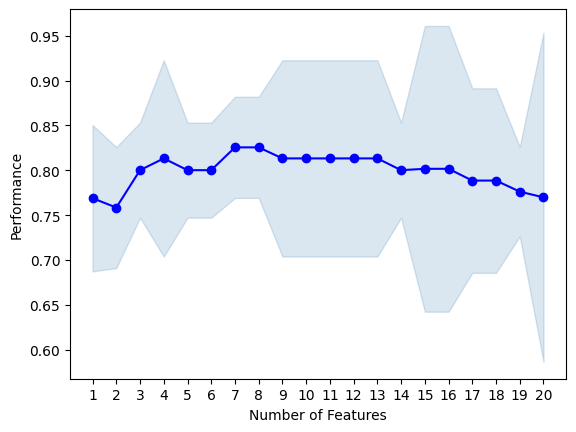

In [62]:
plot_sfs(ftsl.selector.get_metric_dict(), kind='ci')

In [44]:
from feature_selection import FeatureSelector

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=SEED, stratify=y)
kf = get_cross_validation(X_train, y_train, type="leave_one_out")

model = SVC()
kwargs = {"selection_type":"forward", "floating":True, "scoring":"accuracy", "k_features": (10,25), "cv":kf}


ftsl = FeatureSelector(model, **kwargs)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
ftsl = ftsl.fit(X_train, y_train)
results = ftsl.get_results()
results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    1.4s finished
Features: 1/25[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    1.5s finished
Features: 2/25[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s finished
Features: 3/25[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
Features: 4/25[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='Number of Features', ylabel='Performance'>)

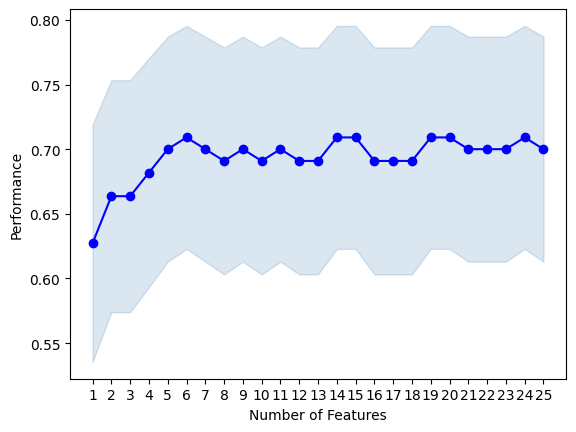

In [64]:
plot_sfs(ftsl.selector.get_metric_dict(), kind='ci')

## Model Tuning
* Grid Search 


First, lets get baselines before tuning with models using features from feature selection and balancing

In [66]:
# standardized cross validation for each search
kf = get_cross_validation(X, y)

In [67]:
# top features for SVC
top_n_features =['weight', 'bimanual score: washer', 'Bimanual Score: Button', 'RT_HR', 'CMT: HR', 'cvRT_HR', 'Ball Path_V', 'Delta_Fullpath', 'Corrective_V', 'AE_HR', 'Delta_AE', 'Delta: VE', 'AbsOnAxis_HR', 'Delta_OnAxis', 'Delta_OffAxis']
X_top_n_features = X[top_n_features]

In [68]:
X_smote, y_smote = balance_dataset(X, y, type="SMOTE")
X_adasyn, y_adasyn = balance_dataset(X, y, type="ADASYN")
X_random, y_random = balance_dataset(X, y, type="RANDOM")
X_knnor, y_knnor = balance_dataset(X, y, type="KNNOR")

In [69]:
# unbalanced, all features
f1_all_features = train_simple_model(SVC(random_state=SEED), get_cross_validation(X, y), X, y)

# top n features
f1_top_n_features = train_simple_model(SVC(random_state=SEED), get_cross_validation(X_top_n_features, y), X_top_n_features, y)

# smote, all features
f1_smote = train_simple_model(SVC(random_state=SEED), get_cross_validation(X_smote, y_smote), X_smote, y_smote)

# adasyn, all features
f1_adasyn = train_simple_model(SVC(random_state=SEED), get_cross_validation(X_adasyn, y_adasyn), X_adasyn, y_adasyn)

# random, all features
f1_random = train_simple_model(SVC(random_state=SEED), get_cross_validation(X_random, y_random), X_random, y_random)

# knnor, all features
f1_knnor = train_simple_model(SVC(random_state=SEED), get_cross_validation(X_knnor, y_knnor), X_knnor, y_knnor)

print(f"f1 all features, unbalanced: {f1_all_features}")
print(f"f1 top n features: {f1_top_n_features}")
print(f"f1 smote: {f1_smote}")
print(f"f1 adasyn: {f1_adasyn}")
print(f"f1 random: {f1_random}")
print(f"f1 knnor: {f1_knnor}")

f1 all features, unbalanced: 0.6910016977928692
f1 top n features: 0.5846846846846847
f1 smote: 0.5769230769230769
f1 adasyn: 0.5603448275862069
f1 random: 0.56
f1 knnor: 0.6103448275862069


In [97]:

model = SVC(random_state=SEED)
hyperparams = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "C": [0.1, 1, 10, 100, 1000],
    "degree": [1, 2, 3, 4, 5, 6],
    "gamma" : ["scale", "auto"],
    "class_weight": ["balanced", None],
    "break_ties": [True, False],
}

features = ['age as of June 1', "bimanual score: washer", "Delta_PV", "MT_HR"]
model_tuner = Tuner(model, hyperparams, cv=get_cross_validation(X[features], y))
model_tuner.tune(X, y)

best_params = model_tuner.get_best_params()
best_estimator = model_tuner.get_best_estimator()
results = model_tuner.get_results()

print("best after model tuning")
print(model_tuner.get_best_estimator(), model_tuner.get_best_score(), model_tuner.get_best_params())

Fitting 2 folds for each of 960 candidates, totalling 1920 fits
best after model tuning
SVC(C=100, break_ties=True, degree=1, kernel='sigmoid', random_state=42) 0.68 {'SVC': {'C': 100, 'break_ties': True, 'class_weight': None, 'degree': 1, 'gamma': 'scale', 'kernel': 'sigmoid'}}


In [102]:
# feature_set = ['age as of June 1', 'height', 'weight', 'previous concussions?', '# of concussions', 'bimanual score: washer', 'Bimanual Score: Button', 'RT_V', 'Delta_MT', 'CMT: V', 'CMT: HR', 'cvRT_V', 'cvRT_HR', 'stdRT_V', 'stdRT_HR', 'Corrective_V', 'Corrective_HR', 'PeakV_HR', 'AE_HR', 'Delta_AE', 'Delta: VE', 'AbsOnAxis_V', 'Delta_OnAxis', 'AbsOffAxis_V']
feature_set = ['age as of June 1', "bimanual score: washer", "Delta_PV", "MT_HR"]
X2 = X[feature_set]

f1_all_features = train_simple_model(SVC(kernel="poly", random_state=SEED, gamma="scale", C=100, class_weight="balanced", break_ties=False), get_cross_validation(X2, y), X2, y)
f1_all_features

0.7442396313364055

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

f1s = []
for fs in results["features"]:
    fs = list(map(lambda x: x.replace("'", ""), list(fs)))
    X2 = X[fs]
    f_score = train_simple_model( RandomForestClassifier(class_weight='balanced', max_depth=11, max_features=None,
                       min_samples_leaf=4, min_samples_split=5,
                       n_estimators=10), get_cross_validation(X2, y), X2, y)
    f1s.append(f_score)
    print(fs)
    

f1s

['Bimanual Score: Button', 'cvRT_HR', 'FullPath_HR', 'Delta_Fullpath', 'Delta_AE', 'Delta: VE', 'Delta_OffAxis']
['Bimanual Score: Button', 'cvRT_HR', 'FullPath_HR', 'Delta_Fullpath', 'Corrective_V', 'Delta_AE', 'Delta: VE', 'Delta_OffAxis']
['Bimanual Score: Button', 'RT_HR', 'cvRT_HR', 'FullPath_HR', 'Delta_Fullpath', 'Corrective_V', 'AE_HR', 'Delta_AE', 'Delta: VE', 'AbsOnAxis_HR', 'Delta_OffAxis']
['bimanual score: washer', 'Bimanual Score: Button', 'RT_HR', 'cvRT_HR', 'FullPath_HR', 'Delta_Fullpath', 'Corrective_V', 'AE_HR', 'Delta_AE', 'Delta: VE', 'AbsOnAxis_HR', 'Delta_OnAxis', 'Delta_OffAxis']
['Bimanual Score: Button', 'RT_HR', 'cvRT_HR', 'FullPath_HR', 'Delta_Fullpath', 'Corrective_V', 'AE_HR', 'Delta_AE', 'Delta: VE', 'AbsOnAxis_HR', 'Delta_OnAxis', 'Delta_OffAxis']
['Bimanual Score: Button', 'RT_HR', 'cvRT_HR', 'FullPath_HR', 'Delta_Fullpath', 'Corrective_V', 'AE_HR', 'Delta_AE', 'Delta: VE', 'Delta_OffAxis']
['Bimanual Score: Button', 'cvRT_HR', 'FullPath_HR', 'Delta_Full

[0.6071428571428571,
 0.5333333333333333,
 0.5436507936507937,
 0.5066137566137566,
 0.5794044665012408,
 0.4580645161290323,
 0.6066666666666667,
 0.6993548387096775,
 0.59375,
 0.5770609318996416,
 0.5967016491754122,
 0.6786140979689368,
 0.6466666666666667,
 0.5158620689655171,
 0.5285714285714286,
 0.5026525198938991,
 0.6629588431590656,
 0.6045751633986929,
 0.5821114369501466,
 0.7459770114942528]